# Data Exploration for a Machine Learning Stock Predictor

In [435]:
# import needed libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
---

Global functions intended to make computations easier. These are also developed with the intention to be used in the final code implimentaion

In [436]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    ticker_list.insert(0, 'SPY')
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################
def normalize_data(df):
    return df/df.ix[0,:]

def get_cumulative_returns(df):
    return df/df.ix[0,:]

def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.ix[0, : ] = 0
    return daily_returns

# rolling stats
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

def get_bollinger_ratios(series, sma, r_std, window=20):
    br = series.copy()
    br[window:] = (br[window:] - sma[window:]) / (2 * r_std[window:])
    return br[window:]

def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='Bollinger Bands: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
################################################
# Machine Learning Models
################################################

## Process Data for Selected Stocks
---

In [437]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# These will be the tickers we will be working with to build our model
# SPY is added as a benchmark model. 
tickers = ['NVDA']

# fetch the data for the dates and tickers selected
# df_full_data = fetch_data(tickers, dates)
# df_explore = df_full_data.drop('SPY', 1)

df_explore = fetch_data(tickers, dates)

# print 'Total days traded during dates: ' + str(len(df_explore))
# print df_full_data.head(n=5)
# print '\nCreate a new DF without SnP 500, since it was only used to varify trading days. But we may still want it for some comparisons.'
print df_explore.head(n=5)

                   SPY       NVDA
2015-07-14  210.679993  19.889999
2015-07-15  210.610001  19.750000
2015-07-16  212.300003  20.190001
2015-07-17  212.479996  20.070000
2015-07-20  212.589996  19.700001


## Visualize the Data of the Selected Stocks
---


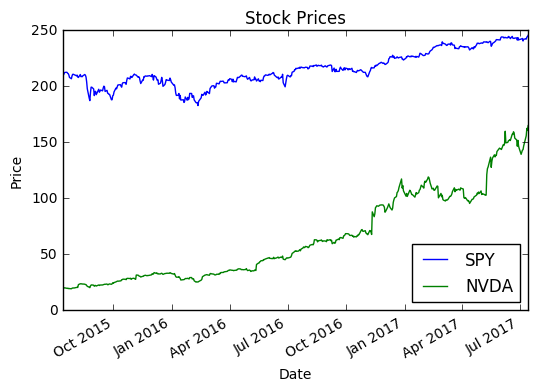

In [438]:
plot_data(df_explore)

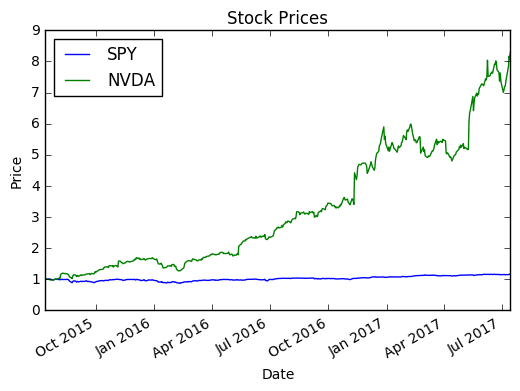

In [439]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

## Global Stats
---

Global stats of the stocks we are interested in

---

In [440]:
print 'Global Mean:\n' + str(df_explore.mean()) + '\n'
print 'Global Median:\n' + str(df_explore.median()) + '\n'
print 'Global Std:\n' + str(df_explore.std()) + '\n'

Global Mean:
SPY     215.291976
NVDA     64.573142
dtype: float64

Global Median:
SPY     212.509995
NVDA     52.789999
dtype: float64

Global Std:
SPY     15.365571
NVDA    39.429432
dtype: float64



## Rolling Stats
---

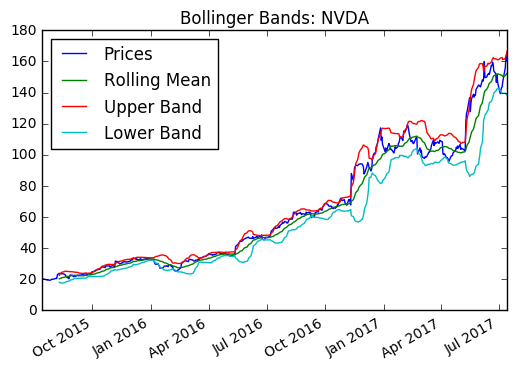

In [441]:
rolling_mean = get_rolling_mean(df_explore['NVDA'])
rolling_std = get_rolling_std(df_explore['NVDA'])
lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)

print_bollinger_bands(df_explore['NVDA'], rolling_mean, lower_band, upper_band, 'NVDA')

## Daily Returns
---

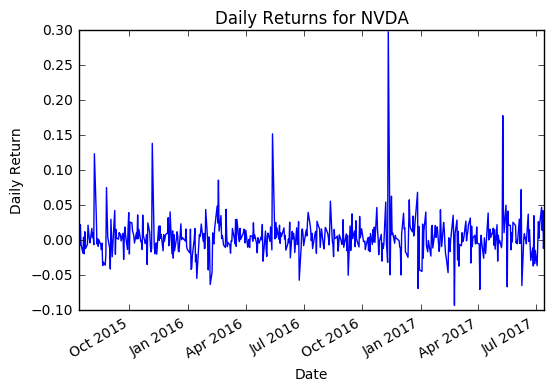

0.298067063512
-0.0927230391347


In [442]:
daily_returns  = get_daily_returns(df_explore)
plot_data(daily_returns['NVDA'], title='Daily Returns for NVDA', xlabel='Date', ylabel='Daily Return')
print daily_returns['NVDA'].max()
print daily_returns['NVDA'].min()

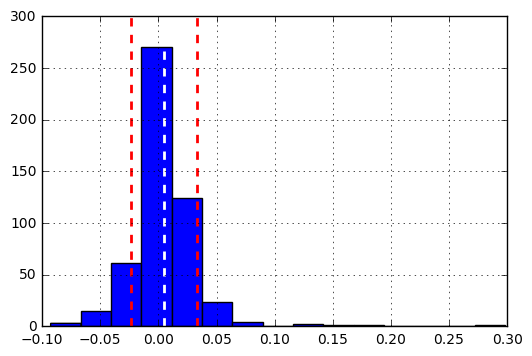

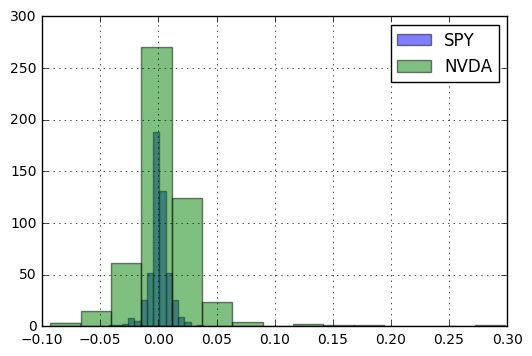

In [443]:
plot_hist_with_stats(daily_returns['NVDA'], bins=15, title=stock)
plot_hist_multi(daily_returns, bins=15)

## Cumulative Returns
---

## Momentum
---

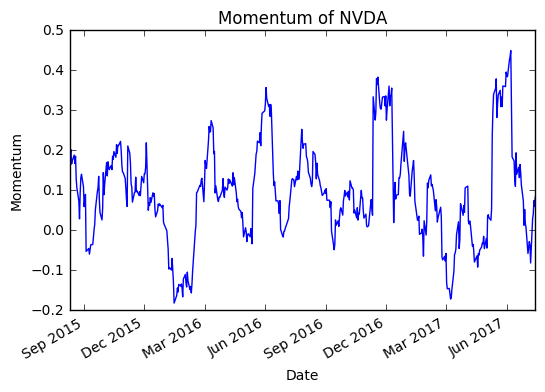

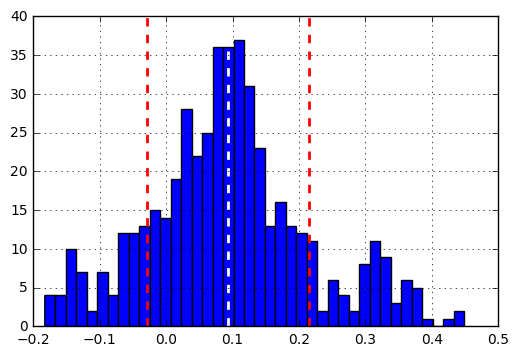

0.44861076455
-0.182695127084


In [444]:
# momentum at a 20 day window size. 
momentum = get_momentum(df_explore)
plot_data(momentum['NVDA'], title='Momentum of NVDA', xlabel='Date', ylabel='Momentum')
plot_hist_with_stats(momentum['NVDA'], bins=40, title='NVDA')

print momentum['NVDA'].max()
print momentum['NVDA'].min()

## Simple Moving Average Ratio
---

486


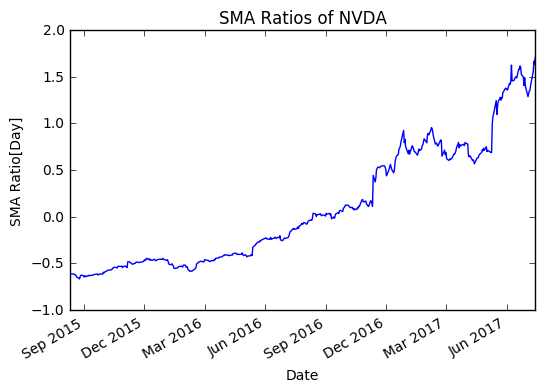

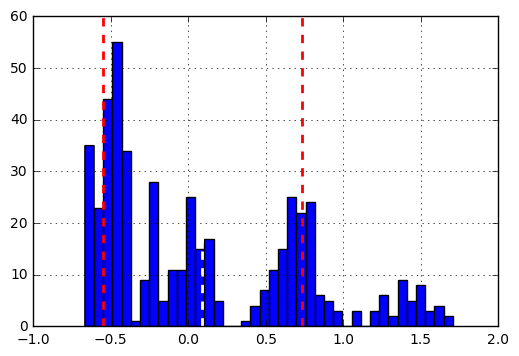

1.70607908496
-0.667297438331


In [445]:
sma_ratios = get_sma_ratio(df_explore)

print len(sma_ratios)

plot_data(sma_ratios['NVDA'], title='SMA Ratios of NVDA', xlabel='Date', ylabel='SMA Ratio[Day]')
plot_hist_with_stats(sma_ratios['NVDA'], bins=40, title='NVDA')

print sma_ratios['NVDA'].max()
print sma_ratios['NVDA'].min()

## Bolinger Ratios
---

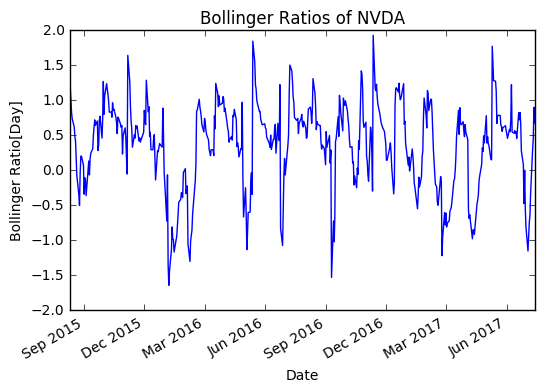

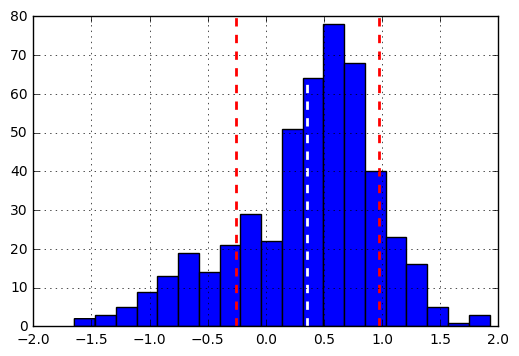

1.92449192427
-1.64666566918


In [446]:
br_ratios = get_bollinger_ratios(df_explore['NVDA'], rolling_mean, rolling_std)

plot_data(br_ratios, title='Bollinger Ratios of NVDA', xlabel='Date', ylabel='Bollinger Ratio[Day]')
plot_hist_with_stats(br_ratios, bins=20, title='NVDA')

print br_ratios.max()
print br_ratios.min()